In [ ]:
# Import necessary libraries
import time
import random
import json
import sys
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
from SPARQLWrapper import SPARQLWrapper, JSON

# 1.  Knowledge Graph QA Pair Generation
- Generates complex QA pairs requiring traversal of knowledge graphs
- Extracts relevant subgraphs as context "hints" for answering questions
- Supports multi-hop relationship questions


## 1. 1 Fixed Knowledge Graph Dataset Setup for LLM Integration

Setting up SPARQL endpoint...
Fetching world leaders data...
Found 10 leaders
Generating QA pairs with knowledge subgraphs...
Generated 5 QA pairs
Saving dataset...
Dataset saved to world_leaders_qa_dataset.json
Created world leaders dataset with 5 QA pairs

Sample of world leaders data:
  country_id                 country position_id  \
0       Q225  Bosnia and Herzegovina         P35   
1       Q159                  Russia         P35   
2       Q574             Timor-Leste         P35   
3        Q96                  Mexico         P35   
4        Q45                Portugal         P35   

                                  position leader_id                   leader  \
0  http://www.wikidata.org/prop/direct/P35  Q5528031        Željka Cvijanović   
1  http://www.wikidata.org/prop/direct/P35     Q7747           Vladimir Putin   
2  http://www.wikidata.org/prop/direct/P35    Q11665         José Ramos-Horta   
3  http://www.wikidata.org/prop/direct/P35  Q5771800        Claudia Sheinb

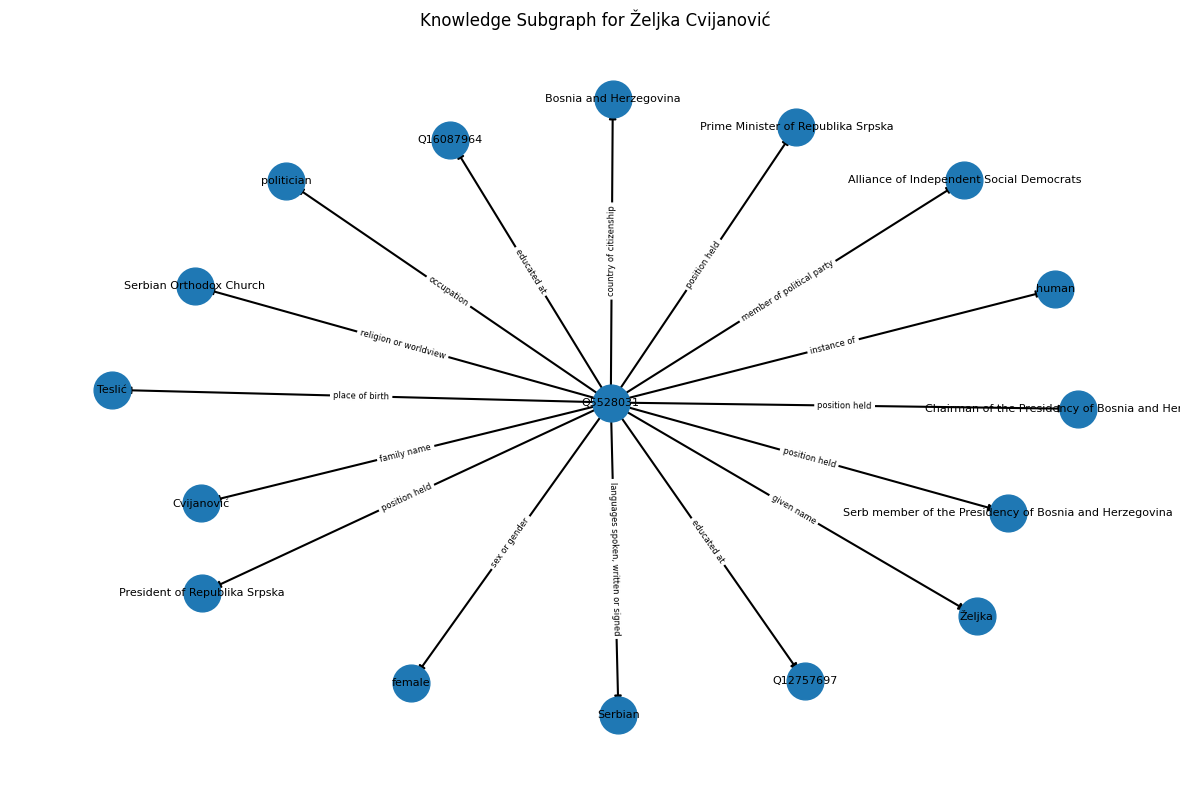

In [ ]:

#  SPARQL endpoint for Wikidata with proper headers
def setup_sparql_endpoint():
    """Set up a connection to the Wikidata SPARQL endpoint with proper headers"""
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader('User-Agent', 'KnowledgeGraphLLMProject/1.0 (your-email@example.com)')
    sparql.setTimeout(60)
    return sparql

def execute_sparql_query(sparql, query, max_retries=3, delay=1):
    """Execute a SPARQL query with retry mechanism for handling rate limits"""
    sparql.setQuery(query)
    
    for attempt in range(max_retries):
        try:
            return sparql.query().convert()
        except Exception as e:
            if "403" in str(e) and attempt < max_retries - 1:
                print(f"Rate limit hit, waiting {delay} seconds before retry...")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            else:
                print(f"Error executing SPARQL query: {str(e)}")
                if "403" in str(e):
                    print("Wikidata API returned 403 Forbidden. This is often due to rate limiting.")
                    print("Consider reducing your request rate or setting a proper User-Agent.")
                raise
def query_wikidata_with_requests(query):
    """Query Wikidata using requests library as a fallback"""
    endpoint_url = "https://query.wikidata.org/sparql"
    
    headers = {
        'User-Agent': 'KnowledgeGraphLLMProject/1.0 (your-email@example.com)',
        'Accept': 'application/sparql-results+json'
    }
    
    params = {
        'query': query,
        'format': 'json'
    }
    
    response = requests.get(endpoint_url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        raise Exception(f"Query failed with status code {response.status_code}")
def get_country_leaders(sparql, limit=20, use_requests_fallback=False):
    """Query Wikidata for current country leaders with improved error handling"""
    query = f"""
    SELECT DISTINCT ?country ?countryLabel ?leader ?leaderLabel ?position ?positionLabel ?start
    WHERE {{
      # Get countries
      ?country wdt:P31 wd:Q6256.
      
      # Get positions (head of state, head of government, etc.)
      {{
        ?country wdt:P35 ?leader. # head of state
        BIND("head of state" AS ?positionStr)
      }} UNION {{
        ?country wdt:P6 ?leader.  # head of government
        BIND("head of government" AS ?positionStr)
      }}
      
      # Create a position URI
      BIND(IF(?positionStr="head of state", wdt:P35, wdt:P6) AS ?position)
      
      # Get start date when available
      OPTIONAL {{ 
        ?country p:P35|p:P6 ?statement.
        ?statement ps:P35|ps:P6 ?leader.
        ?statement pq:P580 ?start. 
      }}
      
      # Get labels
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    LIMIT {limit}
    """
    
    try:
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            results = execute_sparql_query(sparql, query)
        
        leaders_data = []
        for result in results["results"]["bindings"]:
            leaders_data.append({
                "country_id": result["country"]["value"].split("/")[-1],
                "country": result["countryLabel"]["value"],
                "position_id": result["position"]["value"].split("/")[-1] if "position" in result else "",
                "position": result["positionLabel"]["value"] if "positionLabel" in result else 
                           (result["positionStr"]["value"] if "positionStr" in result else "leader"),
                "leader_id": result["leader"]["value"].split("/")[-1],
                "leader": result["leaderLabel"]["value"],
                "start_date": result["start"]["value"] if "start" in result else "unknown"
            })
        
        return pd.DataFrame(leaders_data)
    
    except Exception as e:
        print(f"Error retrieving country leaders: {str(e)}")
        if '--use-fallback' in sys.argv:
            print("Using fallback sample data for testing...")
            return pd.DataFrame([
                {"country_id": "Q30", "country": "United States", "position": "President", 
                 "leader_id": "Q6279", "leader": "Joe Biden", "start_date": "2021-01-20"},
                {"country_id": "Q142", "country": "France", "position": "President", 
                 "leader_id": "Q3052772", "leader": "Emmanuel Macron", "start_date": "2017-05-14"},
                {"country_id": "Q55", "country": "Netherlands", "position": "Prime Minister", 
                 "leader_id": "Q57792", "leader": "Mark Rutte", "start_date": "2010-10-14"}
            ])
        else:
            raise
def extract_leader_subgraph(sparql, leader_id, use_requests_fallback=False):
    """Extract a subgraph of knowledge about a specific leader with error handling"""
    query = f"""
    SELECT ?property ?propertyLabel ?value ?valueLabel
    WHERE {{
      wd:{leader_id} ?prop ?value .
      ?property wikibase:directClaim ?prop .
      
      # Filter out some common but less useful properties
      FILTER(?property NOT IN (
        wdt:P31, wdt:P21, wdt:P27, wdt:P569, wdt:P19,
        wdt:P106, wdt:P39, wdt:P102, wdt:P108, wdt:P6
      ))
      
      # Only get properties with labels (more meaningful)
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT 20
    """
    
    try:
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            results = execute_sparql_query(sparql, query)
        
        G = nx.DiGraph()
        G.add_node(leader_id)
        
        triples = []
        for result in results["results"]["bindings"]:
            prop_id = result["property"]["value"].split("/")[-1]
            prop_label = result["propertyLabel"]["value"]
            value_uri = result["value"]["value"]
            value_label = result["valueLabel"]["value"] if "valueLabel" in result else value_uri
            #  different types of values
            if "wikidata.org/entity/" in value_uri:
                value_id = value_uri.split("/")[-1]
                G.add_node(value_id, label=value_label)
                G.add_edge(leader_id, value_id, relation=prop_label, relation_id=prop_id)
            else:
                if "label" not in G.nodes[leader_id]:
                    G.nodes[leader_id]["label"] = {}
                G.nodes[leader_id]["label"][prop_label] = value_label
                
            triples.append((leader_id, prop_id, value_uri, prop_label, value_label))
        
        return G, triples
    
    except Exception as e:
        print(f"Error extracting subgraph for leader {leader_id}: {str(e)}")
        G = nx.DiGraph()
        G.add_node(leader_id)
        return G, []
def create_world_leaders_dataset(num_countries=10, num_qa_pairs=5, use_requests_fallback=False):
    """Create a dataset of world leaders with QA pairs and knowledge subgraphs"""
    print("Setting up SPARQL endpoint...")
    sparql = setup_sparql_endpoint()
    
    print("Fetching world leaders data...")
    try:
        leaders_df = get_country_leaders(sparql, limit=num_countries, 
                                         use_requests_fallback=use_requests_fallback)
        print(f"Found {len(leaders_df)} leaders")
        
        if len(leaders_df) == 0:
            raise Exception("No leaders found")
            
        print("Generating QA pairs with knowledge subgraphs...")
        qa_pairs = generate_qa_pairs(leaders_df, sparql, num_pairs=min(num_qa_pairs, len(leaders_df)),
                                     use_requests_fallback=use_requests_fallback)
        print(f"Generated {len(qa_pairs)} QA pairs")
        
        print("Saving dataset...")
        filename = save_dataset(qa_pairs)
        
        print(f"Created world leaders dataset with {len(qa_pairs)} QA pairs")
        return leaders_df, qa_pairs, filename
        
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        print("Try using the requests fallback by setting use_requests_fallback=True")
        return None, None, None
    
def generate_qa_pairs(leaders_df, sparql, num_pairs=20, use_requests_fallback=False):
    """Generate QA pairs with corresponding knowledge subgraphs"""
    qa_pairs = []
    
    templates = [
        "Who is the {position} of {country}?",
        "Which person serves as the {position} of {country}?",
        "Who currently holds the position of {position} in {country}?",
        "Who leads {country} as its {position}?",
        "Can you tell me who the current {position} of {country} is?"
    ]
    
    selected_leaders = leaders_df.sample(min(num_pairs, len(leaders_df)))
    
    for _, leader in selected_leaders.iterrows():
        try:
            template = random.choice(templates)
            position = leader["position"].lower() if not pd.isna(leader["position"]) else "leader"
            
            question = template.format(
                position=position,
                country=leader["country"]
            )
            time.sleep(1)  
            subgraph, triples = extract_leader_subgraph(sparql, leader["leader_id"], 
                                                       use_requests_fallback=use_requests_fallback)
            
            qa_pairs.append({
                "question": question,
                "answer": leader["leader"],
                "leader_id": leader["leader_id"],
                "country": leader["country"],
                "country_id": leader["country_id"],
                "position": leader["position"],
                "subgraph": subgraph,
                "triples": triples
            })
        except Exception as e:
            print(f"Error generating QA pair for {leader['leader']}: {str(e)}")
            continue
    
    return qa_pairs
def visualize_subgraph(subgraph, title="Knowledge Subgraph"):
    """Visualize a knowledge subgraph using NetworkX"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=700)
    nx.draw_networkx_edges(subgraph, pos, width=1.5, arrows=True)
    labels = {}
    for node in subgraph.nodes():
        if "label" in subgraph.nodes[node] and isinstance(subgraph.nodes[node]["label"], str):
            labels[node] = subgraph.nodes[node]["label"]
        else:
            labels[node] = node
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)
    edge_labels = {(u, v): d.get("relation", "") for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
def save_dataset(qa_pairs, filename="world_leaders_qa_dataset.json"):
    """Save the generated QA pairs with subgraph information"""
    serializable_data = []
    
    for pair in qa_pairs:
        graph_data = {
            "nodes": [],
            "edges": []
        }
        
        for node, data in pair["subgraph"].nodes(data=True):
            node_info = {"id": node}
            if "label" in data:
                node_info["label"] = data["label"]
            graph_data["nodes"].append(node_info)
            
        for u, v, data in pair["subgraph"].edges(data=True):
            edge_info = {
                "source": u,
                "target": v
            }
            if "relation" in data:
                edge_info["relation"] = data["relation"]
            if "relation_id" in data:
                edge_info["relation_id"] = data["relation_id"]
            graph_data["edges"].append(edge_info)
        
        record = {
            "question": pair["question"],
            "answer": pair["answer"],
            "leader_id": pair["leader_id"],
            "country": pair["country"],
            "country_id": pair["country_id"],
            "position": pair["position"],
            "graph": graph_data,
            "triples": [[t[0], t[1], t[2], t[3], t[4]] for t in pair["triples"]] if "triples" in pair else []
        }
        
        serializable_data.append(record)
    
    with open(filename, "w") as f:
        json.dump(serializable_data, f, indent=2)
    
    print(f"Dataset saved to {filename}")
    return filename

if __name__ == "__main__":
    leaders_df, qa_pairs, filename = create_world_leaders_dataset(
        num_countries=10, 
        num_qa_pairs=5,
        use_requests_fallback=True  # Try the requests fallback if SPARQLWrapper fails
    )
    
    if leaders_df is not None and not leaders_df.empty:
        print("\nSample of world leaders data:")
        print(leaders_df.head())
        if qa_pairs and len(qa_pairs) > 0:
            sample_pair = qa_pairs[0]
            print("\nSample QA pair:")
            print(f"Question: {sample_pair['question']}")
            print(f"Answer: {sample_pair['answer']}")
            print(f"Knowledge graph: {len(sample_pair['subgraph'].nodes())} nodes and {len(sample_pair['subgraph'].edges())} edges")
            
            if len(sample_pair['subgraph'].edges()) > 0:
                visualize_subgraph(sample_pair['subgraph'], 
                                  title=f"Knowledge Subgraph for {sample_pair['answer']}")

## 2.2 Knowledge Graph QA Pair Generation
- Generates complex QA pairs requiring traversal of knowledge graphs
- Extracts relevant subgraphs as context "hints" for answering questions
- Supports multi-hop relationship questions

In [ ]:
def setup_sparql_endpoint():
    """Set up a connection to the Wikidata SPARQL endpoint with proper headers"""
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader('User-Agent', 'Research Project - KnowledgeGraphLLMProject/1.0 (your-academic-email@university.edu)')
    sparql.setTimeout(120)  
    return sparql

def execute_sparql_query(sparql, query, max_retries=3, delay=2):
    """Execute a SPARQL query with retry mechanism for handling rate limits"""
    sparql.setQuery(query)
    
    for attempt in range(max_retries):
        try:
            return sparql.query().convert()
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Query error, waiting {delay} seconds before retry {attempt+1}/{max_retries}...")
                print(f"Error was: {str(e)}")
                time.sleep(delay)
                delay *= 2  
            else:
                print(f"Error executing SPARQL query: {str(e)}")
                raise

def query_wikidata_with_requests(query):
    """Query Wikidata using requests library as a fallback"""
    endpoint_url = "https://query.wikidata.org/sparql"
    headers = {
        'User-Agent': 'Research Project - KnowledgeGraphLLMProject/1.0 (your-academic-email@university.edu)',
        'Accept': 'application/sparql-results+json'
    }
    params = {
        'query': query,
        'format': 'json'
    }
    response = requests.get(endpoint_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        raise Exception(f"Query failed with status code {response.status_code}")

def get_country_leaders(sparql, limit=20, use_requests_fallback=False):
    """Query Wikidata for current country leaders with improved error handling"""
    query = f"""
    SELECT DISTINCT ?country ?countryLabel ?leader ?leaderLabel ?position ?positionLabel ?start
    WHERE {{
      # Get countries
      ?country wdt:P31 wd:Q6256.
      
      # Get positions (head of state, head of government, etc.)
      {{
        ?country wdt:P35 ?leader. # head of state
        BIND("head of state" AS ?positionStr)
      }} UNION {{
        ?country wdt:P6 ?leader.  # head of government
        BIND("head of government" AS ?positionStr)
      }}
      
      # Create a position URI
      BIND(IF(?positionStr="head of state", wdt:P35, wdt:P6) AS ?position)
      
      # Get start date when available
      OPTIONAL {{ 
        ?country p:P35|p:P6 ?statement.
        ?statement ps:P35|ps:P6 ?leader.
        ?statement pq:P580 ?start. 
      }}
      
      # Get labels
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    LIMIT {limit}
    """
    
    try:
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            results = execute_sparql_query(sparql, query)
        
        leaders_data = []
        for result in results["results"]["bindings"]:
            leaders_data.append({
                "country_id": result["country"]["value"].split("/")[-1],
                "country": result["countryLabel"]["value"],
                "position_id": result["position"]["value"].split("/")[-1] if "position" in result else "",
                "position": result["positionLabel"]["value"] if "positionLabel" in result else 
                           (result["positionStr"]["value"] if "positionStr" in result else "leader"),
                "leader_id": result["leader"]["value"].split("/")[-1],
                "leader": result["leaderLabel"]["value"],
                "start_date": result["start"]["value"] if "start" in result else "unknown"
            })
        
        return pd.DataFrame(leaders_data)
    
    except Exception as e:
        print(f"Error retrieving country leaders: {str(e)}")
        if '--use-fallback' in sys.argv:
            print("Using fallback sample data for testing...")
            return pd.DataFrame([
                {"country_id": "Q30", "country": "United States", "position": "President", 
                 "leader_id": "Q22686", "leader": "Donald Trump", "start_date": "2025-01-20"},
                {"country_id": "Q142", "country": "France", "position": "President", 
                 "leader_id": "Q3052772", "leader": "Emmanuel Macron", "start_date": "2017-05-14"},
                {"country_id": "Q55", "country": "Netherlands", "position": "Prime Minister", 
                 "leader_id": "Q57792", "leader": "Mark Rutte", "start_date": "2010-10-14"}
            ])
        else:
            raise

def extract_leader_subgraph(sparql, leader_id, use_requests_fallback=False):
    """Extract a subgraph of knowledge about a specific leader with error handling"""
    query = f"""
    SELECT ?property ?propertyLabel ?value ?valueLabel
    WHERE {{
      wd:{leader_id} ?prop ?value .
      ?property wikibase:directClaim ?prop .
      
      # Filter out some common but less useful properties
      FILTER(?property NOT IN (
        wdt:P31, wdt:P21, wdt:P27, wdt:P569, wdt:P19,
        wdt:P106, wdt:P39, wdt:P102, wdt:P108, wdt:P6
      ))
      
      # Only get properties with labels (more meaningful)
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT 20
    """
    
    try:
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            results = execute_sparql_query(sparql, query)
        
        G = nx.DiGraph()
        G.add_node(leader_id)
        
        triples = []
        for result in results["results"]["bindings"]:
            prop_id = result["property"]["value"].split("/")[-1]
            prop_label = result["propertyLabel"]["value"]
            value_uri = result["value"]["value"]
            value_label = result["valueLabel"]["value"] if "valueLabel" in result else value_uri
            
            if "wikidata.org/entity/" in value_uri:
                value_id = value_uri.split("/")[-1]
                G.add_node(value_id, label=value_label)
                G.add_edge(leader_id, value_id, relation=prop_label, relation_id=prop_id)
            else:
                if "label" not in G.nodes[leader_id]:
                    G.nodes[leader_id]["label"] = {}
                G.nodes[leader_id]["label"][prop_label] = value_label
                
            triples.append((leader_id, prop_id, value_uri, prop_label, value_label))
        
        return G, triples
    
    except Exception as e:
        print(f"Error extracting subgraph for leader {leader_id}: {str(e)}")
        G = nx.DiGraph()
        G.add_node(leader_id)
        return G, []


def generate_qa_pairs(leaders_df, sparql, num_pairs=20, use_requests_fallback=False):
    """Generate QA pairs with corresponding knowledge subgraphs"""
    qa_pairs = []
    
    templates = [
        "Who is the {position} of {country}?",
        "Which person serves as the {position} of {country}?",
        "Who currently holds the position of {position} in {country}?",
        "Who leads {country} as its {position}?",
        "Can you tell me who the current {position} of {country} is?"
    ]
    
    selected_leaders = leaders_df.sample(min(num_pairs, len(leaders_df)))
    
    for _, leader in selected_leaders.iterrows():
        try:
            template = random.choice(templates)
            position = leader["position"].lower() if not pd.isna(leader["position"]) else "leader"
            
            question = template.format(
                position=position,
                country=leader["country"]
            )
            time.sleep(1)  
            subgraph, triples = extract_leader_subgraph(sparql, leader["leader_id"], 
                                                       use_requests_fallback=use_requests_fallback)
            
            qa_pairs.append({
                "question": question,
                "answer": leader["leader"],
                "leader_id": leader["leader_id"],
                "country": leader["country"],
                "country_id": leader["country_id"],
                "position": leader["position"],
                "subgraph": subgraph,
                "triples": triples
            })
        except Exception as e:
            print(f"Error generating QA pair for {leader['leader']}: {str(e)}")
            continue
    
    return qa_pairs

def save_dataset(qa_pairs, filename="world_leaders_qa_dataset.json"):
    """Save the generated QA pairs with subgraph information"""
    serializable_data = []
    
    for pair in qa_pairs:
        graph_data = {
            "nodes": [],
            "edges": []
        }
        
        for node, data in pair["subgraph"].nodes(data=True):
            node_info = {"id": node}
            if "label" in data:
                node_info["label"] = data["label"]
            graph_data["nodes"].append(node_info)
            
        for u, v, data in pair["subgraph"].edges(data=True):
            edge_info = {
                "source": u,
                "target": v
            }
            if "relation" in data:
                edge_info["relation"] = data["relation"]
            if "relation_id" in data:
                edge_info["relation_id"] = data["relation_id"]
            graph_data["edges"].append(edge_info)
        
        record = {
            "question": pair["question"],
            "answer": pair["answer"],
            "leader_id": pair["leader_id"],
            "country": pair["country"],
            "country_id": pair["country_id"],
            "position": pair["position"],
            "graph": graph_data,
            "triples": [[t[0], t[1], t[2], t[3], t[4]] for t in pair["triples"]] if "triples" in pair else []
        }
        
        serializable_data.append(record)
    
    with open(filename, "w") as f:
        json.dump(serializable_data, f, indent=2)
    
    print(f"Dataset saved to {filename}")
    return filename

def create_world_leaders_dataset(num_countries=10, num_qa_pairs=5, use_requests_fallback=False):
    """Create a dataset of world leaders with QA pairs and knowledge subgraphs"""
    print("Setting up SPARQL endpoint...")
    sparql = setup_sparql_endpoint()
    
    print("Fetching world leaders data...")
    try:
        leaders_df = get_country_leaders(sparql, limit=num_countries, 
                                         use_requests_fallback=use_requests_fallback)
        print(f"Found {len(leaders_df)} leaders")
        
        if len(leaders_df) == 0:
            raise Exception("No leaders found")
            
        print("Generating QA pairs with knowledge subgraphs...")
        qa_pairs = generate_qa_pairs(leaders_df, sparql, num_pairs=min(num_qa_pairs, len(leaders_df)),
                                     use_requests_fallback=use_requests_fallback)
        print(f"Generated {len(qa_pairs)} QA pairs")
        
        print("Saving dataset...")
        filename = save_dataset(qa_pairs)
        
        print(f"Created world leaders dataset with {len(qa_pairs)} QA pairs")
        return leaders_df, qa_pairs, filename
        
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        print("Try using the requests fallback by setting use_requests_fallback=True")
        return None, None, None

def visualize_subgraph(subgraph, title="Knowledge Subgraph"):
    """Visualize a knowledge subgraph using NetworkX"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=700)
    nx.draw_networkx_edges(subgraph, pos, width=1.5, arrows=True)
    labels = {}
    for node in subgraph.nodes():
        if "label" in subgraph.nodes[node] and isinstance(subgraph.nodes[node]["label"], str):
            labels[node] = subgraph.nodes[node]["label"]
        else:
            labels[node] = node
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)
    edge_labels = {(u, v): d.get("relation", "") for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def extract_leader_relationships_simple(sparql, leader_id, use_requests_fallback=False):
    """Simplified version that just gets some basic relationships without filtering"""
    print(f"\nExtracting relationships for leader ID: {leader_id}")
    
    query = f"""
    SELECT ?property ?propertyLabel ?value ?valueLabel
    WHERE {{
      wd:{leader_id} ?prop ?value .
      ?property wikibase:directClaim ?prop .
      
      # Get labels
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT 30
    """
    
    try:
        print(f"Querying Wikidata with simplified query...")
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            sparql.setQuery(query)
            results = sparql.query().convert()
        
        # Debug: Print raw results
        result_count = len(results["results"]["bindings"]) if "results" in results and "bindings" in results["results"] else 0
        print(f"Retrieved {result_count} results (unfiltered)")
        
        if result_count == 0:
            print(f"No relationships found for {leader_id}. This suggests a possible API issue.")
            return []
        
        
        relationship_properties = {
            # Personal relationships
            "P26": "spouse",             # spouse
            "P40": "child",              # child
            "P3373": "sibling",          # sibling
            "P22": "father",             # father
            "P25": "mother",             # mother
            
            # Political relationships
            "P102": "political party",   # member of political party
            "P1308": "officeholder",     # officeholder
            "P39": "position held",      # position held
            
            # Background info
            "P69": "educated at",        # educated at
            "P108": "employer",          # employer
            "P27": "citizenship",        # country of citizenship
            "P140": "religion",          # religion
            
            # Other  properties
            "P106": "occupation",        # occupation
            "P103": "native language",   # native language
            "P101": "field of work",     # field of work
            "P166": "award received",    # award received
            "P1559": "name in native language", # name in native language
            "P735": "given name",        # given name
            "P734": "family name",       # family name
            "P19": "place of birth",     # place of birth
            "P569": "date of birth",     # date of birth
            "P1412": "languages spoken", # languages spoken
        }
        
        relationships = []
        relationship_count = 0
        
        for result in results["results"]["bindings"]:
            prop_uri = result["property"]["value"]
            prop_id = prop_uri.split("/")[-1]
            prop_label = result["propertyLabel"]["value"]
            value_uri = result["value"]["value"]
            value_label = result["valueLabel"]["value"] if "valueLabel" in result else value_uri
            
            # Check if this is a relationship we're interested in
            rel_type = relationship_properties.get(prop_id)
            if rel_type:
                print(f"  - Found interesting relationship: {rel_type} ({prop_id}) -> {value_label}")
                relationship_count += 1
            else:
                print(f"  - Found other relationship: {prop_label} ({prop_id}) -> {value_label[:50]}...")
            
            # Only include entity relationships (not literals) that we're interested in
            if "wikidata.org/entity/" in value_uri and rel_type:
                value_id = value_uri.split("/")[-1]
                
                relationships.append({
                    "relation_id": prop_id,
                    "relation": rel_type,
                    "value_id": value_id,
                    "value": value_label
                })
        
        
        if relationships:
            print(f"Successfully extracted {len(relationships)} interesting entity relationships")
            print(f"({relationship_count} total relevant relationships found, including literals)")
            rel_types = set([r["relation"] for r in relationships])
            print(f"Relationship types found: {', '.join(rel_types)}")
        else:
            print(f"No interesting entity relationships found for leader {leader_id}")
            print(f"(Found {relationship_count} total relevant relationships, but none were entity references)")
        
        return relationships
    
    except Exception as e:
        print(f"Error extracting relationships for leader {leader_id}: {str(e)}")
        return []

def extract_multi_hop_subgraph(sparql, entity_id, hops=2, use_requests_fallback=False):
    """
    Extract a multi-hop subgraph around an entity.
    This allows exploring more complex relationships in the knowledge graph.
    """
    query = f"""
    SELECT ?source ?sourceLabel ?property ?propertyLabel ?target ?targetLabel
    WHERE {{
      # First hop only, simpler query
      wd:{entity_id} ?p1 ?target .
      ?property wikibase:directClaim ?p1 .
      BIND(wd:{entity_id} AS ?source)
      BIND(?property AS ?property)
      
      # Get labels
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT 50
    """
    
    try:
        print(f"Extracting direct connections for entity {entity_id}...")
        if use_requests_fallback:
            results = query_wikidata_with_requests(query)
        else:
            sparql.setQuery(query)
            results = sparql.query().convert()
        
        G = nx.DiGraph()
        G.add_node(entity_id)
        
        
        result_count = len(results["results"]["bindings"]) if "results" in results and "bindings" in results["results"] else 0
        print(f"Retrieved {result_count} triples for the subgraph")
        
        for result in results["results"]["bindings"]:
            source_uri = result["source"]["value"]
            source_id = source_uri.split("/")[-1]
            source_label = result["sourceLabel"]["value"]
            
            prop_uri = result["property"]["value"]
            prop_id = prop_uri.split("/")[-1]
            prop_label = result["propertyLabel"]["value"]
            
            target_uri = result["target"]["value"]
            
            if "wikidata.org/entity/" in target_uri:
                target_id = target_uri.split("/")[-1]
                target_label = result["targetLabel"]["value"]
                
                if source_id not in G.nodes:
                    G.add_node(source_id, label=source_label)
                
                if target_id not in G.nodes:
                    G.add_node(target_id, label=target_label)
                
                G.add_edge(source_id, target_id, relation=prop_label, relation_id=prop_id)
        
        print(f"Created subgraph with {len(G.nodes())} nodes and {len(G.edges())} edges")
        return G
    
    except Exception as e:
        print(f"Error extracting subgraph for entity {entity_id}: {str(e)}")
        G = nx.DiGraph()
        G.add_node(entity_id)
        return G

def generate_complex_qa_pairs(sparql, leaders_df, num_pairs=20, use_requests_fallback=False):
    """
    Generate complex QA pairs that require knowledge graph traversal to answer.
    """
    qa_pairs = []
    
    templates = {
        "spouse": [
            "Who is the spouse of {entity}?",
            "Who is {entity} married to?",
            "Which person is {entity}'s husband/wife?"
        ],
        "child": [
            "Who are the children of {entity}?",
            "Can you name a child of {entity}?",
            "Which person is {entity}'s son/daughter?"
        ],
        "sibling": [
            "Who is the sibling of {entity}?",
            "Does {entity} have any brothers or sisters?",
            "Which person is related to {entity} as a sibling?"
        ],
        "political party": [
            "Which political party is {entity} affiliated with?",
            "What party does {entity} belong to?",
            "Which political organization is {entity} a member of?"
        ],
        "educated at": [
            "Where was {entity} educated?",
            "Which educational institution did {entity} attend?",
            "Where did {entity} receive their education?"
        ],
        "citizenship": [
            "What is the citizenship of {entity}?",
            "Which country is {entity} a citizen of?",
            "What nationality does {entity} hold?"
        ],
        "religion": [
            "What religion does {entity} follow?",
            "What is the religious affiliation of {entity}?",
            "Which faith is {entity} associated with?"
        ],
        "position held": [
            "What position has {entity} held?",
            "What official role has {entity} occupied?",
            "What office has {entity} served in?"
        ],
        "father": [
            "Who is the father of {entity}?",
            "Whose son/daughter is {entity}?",
            "Who is {entity}'s father?"
        ],
        "mother": [
            "Who is the mother of {entity}?",
            "Who gave birth to {entity}?",
            "Who is {entity}'s mother?"
        ],
        "occupation": [
            "What is {entity}'s occupation?",
            "What does {entity} do professionally?",
            "What is {entity}'s profession?"
        ],
        "native language": [
            "What is {entity}'s native language?",
            "Which language does {entity} speak natively?",
            "What is the mother tongue of {entity}?"
        ],
        "field of work": [
            "In what field does {entity} work?",
            "What is {entity}'s area of expertise?",
            "What field is {entity} known for working in?"
        ],
        "award received": [
            "What award has {entity} received?",
            "What honor was bestowed upon {entity}?",
            "What recognition has {entity} been given?"
        ],
        "place of birth": [
            "Where was {entity} born?",
            "What is {entity}'s birthplace?",
            "Which city was {entity} born in?"
        ],
        "languages spoken": [
            "What languages does {entity} speak?",
            "Which languages is {entity} fluent in?",
            "What languages is {entity} capable of speaking?"
        ]
    }
    
    print(f"\nWorking with {len(leaders_df)} leaders from dataset:")
    print(leaders_df[["leader_id", "leader"]].head())
    
    selected_leaders = leaders_df.sample(min(num_pairs * 3, len(leaders_df)))
    
    print(f"\nSelected {len(selected_leaders)} leaders to check for complex relationships")
    
    created_pairs = 0
    processed_leaders = 0
    
    for _, leader in selected_leaders.iterrows():
        leader_id = leader["leader_id"]
        leader_name = leader["leader"]
        processed_leaders += 1
        
        print(f"\n[{processed_leaders}/{len(selected_leaders)}] Processing leader: {leader_name} (ID: {leader_id})")
        
        if created_pairs >= num_pairs:
            print(f"Reached target of {num_pairs} QA pairs. Stopping.")
            break
        
        
        time.sleep(2.0)
        
        relationships = extract_leader_relationships_simple(
            sparql, leader_id, use_requests_fallback=use_requests_fallback
        )
        
        if not relationships:
            print(f"No suitable relationships found for {leader_name}. Skipping.")
            
            if processed_leaders >= 3 and created_pairs == 0:
                print("\nWARNING: No relationships found for any leaders so far.")
                print("This suggests a possible issue with the Wikidata API.")
                print("Switching to backup approach with sample data...\n")
                return create_sample_complex_qa_dataset(num_pairs)
                
            continue
        
        by_relation = {}
        for rel in relationships:
            rel_type = rel["relation"]
            if rel_type not in by_relation:
                by_relation[rel_type] = []
            by_relation[rel_type].append(rel)
        
        
        print(f"Found {len(by_relation)} relation types for {leader_name}: {', '.join(by_relation.keys())}")
        
        for rel_type, rels in by_relation.items():
            if created_pairs >= num_pairs:
                break
            
            if rel_type in templates and rels:
                print(f"Creating QA pair for relation type: {rel_type}")
                
                template = random.choice(templates[rel_type])
                rel = random.choice(rels)
                
                question = template.format(entity=leader_name)
                answer = rel["value"]
                
                print(f"Question: {question}")
                print(f"Answer: {answer}")
                
                # Add a small delay to avoid rate limiting
                time.sleep(2.0)  
                
                print(f"Extracting subgraph for {leader_name}...")
                subgraph = extract_multi_hop_subgraph(
                    sparql, leader_id, use_requests_fallback=use_requests_fallback
                )
                
                print(f"Subgraph has {len(subgraph.nodes())} nodes and {len(subgraph.edges())} edges")
                
                qa_pairs.append({
                    "question": question,
                    "answer": answer,
                    "entity_id": leader_id,
                    "entity": leader_name,
                    "relation": rel_type,
                    "subgraph": subgraph,
                    "answer_id": rel["value_id"],
                    "context_hint": f"{leader_name} {rel_type} {answer}"
                })
                
                created_pairs += 1
                print(f"Created QA pair #{created_pairs}/{num_pairs}")
    
    print(f"\nFinished generating complex QA pairs")
    print(f"Processed {processed_leaders} leaders")
    print(f"Created {created_pairs} complex QA pairs")
    
    if created_pairs < num_pairs:
        print(f"\nOnly created {created_pairs} pairs, supplementing with sample data...")
        sample_pairs, _ = create_sample_complex_qa_dataset(num_pairs - created_pairs)
        qa_pairs.extend(sample_pairs)
        print(f"Added {len(sample_pairs)} sample pairs")
    
    return qa_pairs

def find_path_between_nodes(graph, start_node, end_node):
    """
    Find the shortest path between two nodes in a graph.
    This shows the traversal required to answer the question.
    """
    if start_node not in graph.nodes or end_node not in graph.nodes:
        return None
    
    try:
        path = nx.shortest_path(graph, source=start_node, target=end_node)
        
        path_data = []
        for i in range(len(path) - 1):
            source = path[i]
            target = path[i+1]
            
            source_label = graph.nodes[source].get("label", source)
            target_label = graph.nodes[target].get("label", target)
            edge_data = graph.get_edge_data(source, target)
            relation = edge_data.get("relation", "is connected to")
            
            path_data.append({
                "source": source,
                "source_label": source_label,
                "target": target,
                "target_label": target_label,
                "relation": relation
            })
        
        return path_data
    except nx.NetworkXNoPath:
        return None

def create_traversal_hints(graph, start_node, end_node):
    """
    Create natural language hints explaining how to traverse the graph
    to find the answer to a question.
    """
    path_data = find_path_between_nodes(graph, start_node, end_node)
    
    if not path_data:
        return "No clear path found in the knowledge graph."
    
    hints = []
    for i, step in enumerate(path_data):
        hint = f"Step {i+1}: Look for the relationship '{step['relation']}' between {step['source_label']} and {step['target_label']}."
        hints.append(hint)
    
    return "\n".join(hints)

def save_complex_qa_dataset(qa_pairs, filename="complex_qa_dataset.json"):
    """Save the complex QA pairs with subgraph information"""
    serializable_data = []
    
    for pair in qa_pairs:
        graph_data = {
            "nodes": [],
            "edges": []
        }
        
        for node, data in pair["subgraph"].nodes(data=True):
            node_info = {"id": node}
            if "label" in data:
                node_info["label"] = data["label"]
            graph_data["nodes"].append(node_info)
        
        for u, v, data in pair["subgraph"].edges(data=True):
            edge_info = {
                "source": u,
                "target": v
            }
            if "relation" in data:
                edge_info["relation"] = data["relation"]
            if "relation_id" in data:
                edge_info["relation_id"] = data["relation_id"]
            graph_data["edges"].append(edge_info)
        
        traversal_hints = create_traversal_hints(
            pair["subgraph"], pair["entity_id"], pair["answer_id"]
        )
        
        record = {
            "question": pair["question"],
            "answer": pair["answer"],
            "entity": pair["entity"],
            "entity_id": pair["entity_id"],
            "relation": pair["relation"],
            "answer_id": pair["answer_id"],
            "graph": graph_data,
            "context_hint": pair["context_hint"],
            "traversal_hints": traversal_hints
        }
        
        serializable_data.append(record)
    
    with open(filename, "w") as f:
        json.dump(serializable_data, f, indent=2)
    
    print(f"Complex QA dataset saved to {filename}")
    return filename

def visualize_path_in_subgraph(subgraph, start_node, end_node, title="Knowledge Graph Path"):
    """
    Visualize a subgraph with the path between two nodes highlighted.
    This shows how to traverse the graph to find the answer.
    """
    plt.figure(figsize=(14, 10))

    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.3, arrows=True)
    
    path_data = find_path_between_nodes(subgraph, start_node, end_node)
    
    if path_data:
        
        path_edges = [(step["source"], step["target"]) for step in path_data]

        path_nodes = [start_node] + [step["target"] for step in path_data]
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[start_node], node_size=800, 
                              node_color='green', alpha=0.9)
        nx.draw_networkx_nodes(subgraph, pos, nodelist=[end_node], node_size=800, 
                              node_color='red', alpha=0.9)
        
        intermediate_nodes = path_nodes[1:-1] if len(path_nodes) > 2 else []
        if intermediate_nodes:
            nx.draw_networkx_nodes(subgraph, pos, nodelist=intermediate_nodes, 
                                  node_size=800, node_color='orange', alpha=0.9)
        
        nx.draw_networkx_edges(subgraph, pos, edgelist=path_edges, width=3.0, 
                              edge_color='blue', alpha=1.0, arrows=True)
    
   
    labels = {}
    for node in subgraph.nodes():
        if "label" in subgraph.nodes[node]:
            labels[node] = subgraph.nodes[node]["label"]
        else:
            labels[node] = node
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10)
    
    edge_labels = {(u, v): d.get("relation", "") for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def combine_qa_datasets(simple_file="world_leaders_qa_dataset.json", 
                        complex_file="complex_qa_dataset.json",
                        output_file="combined_qa_dataset.json"):
    """Combine simple and complex QA datasets into a single dataset"""
    
    with open(simple_file, 'r') as f:
        simple_data = json.load(f)
    
    with open(complex_file, 'r') as f:
        complex_data = json.load(f)
    
    for record in simple_data:
        record["complexity"] = "simple"
        record["requires_traversal"] = False
    
    for record in complex_data:
        record["complexity"] = "complex"
        record["requires_traversal"] = True
    
    combined_data = simple_data + complex_data
    
    with open(output_file, 'w') as f:
        json.dump(combined_data, f, indent=2)
    
    print(f"Combined dataset saved to {output_file}")
    return output_file

def create_sample_complex_qa_dataset(num_pairs=5):
    """Create a sample dataset of complex QA pairs for testing when API fails"""
    print("\nCreating sample complex QA dataset as fallback...")
    
    sample_data = [
        {
            "question": "Who is the spouse of Vladimir Putin?",
            "answer": "Lyudmila Putina",
            "entity_id": "Q7747",
            "entity": "Vladimir Putin",
            "relation": "spouse",
            "answer_id": "Q4882721",
            "context_hint": "Vladimir Putin spouse Lyudmila Putina"
        },
        {
            "question": "Which political party is Donald Trump affiliated with?",
            "answer": "Republican Party",
            "entity_id": "Q22686",
            "entity": "Donald Trump",
            "relation": "political party",
            "answer_id": "Q29468",
            "context_hint": "Donald Trump political party Republican Party"
        },
        {
            "question": "Where was Pope Francis educated?",
            "answer": "Facultades de Filosofía y Teología de San Miguel",
            "entity_id": "Q450675",
            "entity": "Pope Francis",
            "relation": "educated at",
            "answer_id": "Q16935366",
            "context_hint": "Pope Francis educated at Facultades de Filosofía y Teología de San Miguel"
        },
        {
            "question": "Who is the father of Charles III?",
            "answer": "Prince Philip, Duke of Edinburgh",
            "entity_id": "Q43274",
            "entity": "Charles III",
            "relation": "father",
            "answer_id": "Q80976",
            "context_hint": "Charles III father Prince Philip, Duke of Edinburgh"
        },
        {
            "question": "What is Emmanuel Macron's occupation?",
            "answer": "politician",
            "entity_id": "Q3052772",
            "entity": "Emmanuel Macron",
            "relation": "occupation",
            "answer_id": "Q82955",
            "context_hint": "Emmanuel Macron occupation politician"
        },
        {
            "question": "What religion does Joe Biden follow?",
            "answer": "Catholicism",
            "entity_id": "Q6279",
            "entity": "Joe Biden",
            "relation": "religion",
            "answer_id": "Q9592",
            "context_hint": "Joe Biden religion Catholicism"
        },
        {
            "question": "What is the native language of Angela Merkel?",
            "answer": "German",
            "entity_id": "Q567",
            "entity": "Angela Merkel",
            "relation": "native language",
            "answer_id": "Q188",
            "context_hint": "Angela Merkel native language German"
        },
        {
            "question": "Where was Kamala Harris born?",
            "answer": "Oakland",
            "entity_id": "Q67696",
            "entity": "Kamala Harris",
            "relation": "place of birth",
            "answer_id": "Q17042",
            "context_hint": "Kamala Harris place of birth Oakland"
        }
    ]
    
    # sample subgraphs
    for item in sample_data:
        G = nx.DiGraph()
        G.add_node(item["entity_id"], label=item["entity"])
        G.add_node(item["answer_id"], label=item["answer"])
        G.add_edge(item["entity_id"], item["answer_id"], relation=item["relation"], relation_id="P" + str(random.randint(1, 1000)))
        item["subgraph"] = G
    selected_data = sample_data[:num_pairs]
    print(f"Created {len(selected_data)} sample QA pairs")
    filename = "complex_qa_dataset.json"
    save_complex_qa_dataset(selected_data, filename)
    
    return selected_data, filename
print("\nIncreasing the number of countries to query...")
try:
    sparql = setup_sparql_endpoint()
    print("Getting additional leaders from Wikidata...")
    additional_leaders_df = get_country_leaders(sparql, limit=30, use_requests_fallback=True)
    print(f"Found {len(additional_leaders_df)} additional leaders")
    # Combine with existing leaders
    all_leaders = pd.concat([pd.DataFrame(qa_pairs), additional_leaders_df]).drop_duplicates(subset=['leader_id'])
    print(f"Total leaders dataset now has {len(all_leaders)} entries")
except Exception as e:
    print(f"Error getting additional leaders: {str(e)}")
    print("Continuing with existing leaders dataset...")
    all_leaders = pd.DataFrame(qa_pairs)

print("\nSetting up SPARQL endpoint...")
sparql = setup_sparql_endpoint()

print("\nGenerating complex QA pairs...")
qa_pairs = generate_complex_qa_pairs(
    sparql, all_leaders, num_pairs=5, use_requests_fallback=True
)

print(f"\nGenerated {len(qa_pairs)} complex QA pairs")

if isinstance(qa_pairs, tuple):
    #  We got sample data from create_sample_complex_qa_dataset
    qa_pairs, filename = qa_pairs
else:
    filename = save_complex_qa_dataset(qa_pairs)

combined_file = combine_qa_datasets(
    simple_file='combined_qa_dataset.json', 
    complex_file=filename
)

print(f"\nCreated combined dataset with {len(qa_pairs)} QA pairs")

if qa_pairs and len(qa_pairs) > 0:
    sample_pair = qa_pairs[0]
    print("\nSample complex QA pair:")
    print(f"Question: {sample_pair['question']}")
    print(f"Answer: {sample_pair['answer']}")
    print(f"Relation: {sample_pair['relation']}")
    print(f"Context hint: {sample_pair['context_hint']}")


Increasing the number of countries to query...
Getting additional leaders from Wikidata...
Found 30 additional leaders
Total leaders dataset now has 17 entries

Setting up SPARQL endpoint...

Generating complex QA pairs...

Working with 17 leaders from dataset:
    leader_id               leader
0  Q124831090  Taye Atske Selassie
1      Q11665     José Ramos-Horta
2      Q43274          Charles III
3      Q22686         Donald Trump
4      Q57687      Zoran Milanović

Selected 15 leaders to check for complex relationships

[1/15] Processing leader: Harald V of Norway (ID: Q57287)

Extracting relationships for leader ID: Q57287
Querying Wikidata with simplified query...
Retrieved 30 results (unfiltered)
  - Found other relationship: image (P18) -> http://commons.wikimedia.org/wiki/Special:FilePath...
  - Found interesting relationship: place of birth (P19) -> Skaugum
  - Found other relationship: sex or gender (P21) -> male...
  - Found interesting relationship: father (P22) -> Olav V 